# Importar librerías

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
import seaborn as sns
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

# Análisis exploratorio de datos (EDA)

## Base de datos inicial

In [2]:
df0 = pd.read_csv("Siderophore_DB.csv", index_col="ID")
df0.head()

,Compounds,Microorganism,hydroxamate,catecholate,a-hydroxycarboxylate,carboxylate,phenolate,citrate,other,SMILES,validate smiles,SMARTS,SELFIES
ID,,,,,,,,,,,,,
1,"2,3-dihydroxybenzoic acid","Azobacter vinelandii, Azospirillum lipoferum, ...",0,1,0,1,0,0,0,OC(=O)c1c(O)c(O)ccc1,True,[#8]-[#6](=[#8])-[#6]1:[#6](-[#8]):[#6](-[#8])...,[O][C][=Branch1][C][=O][C][=C][Branch1][C][O][...
2,"2,3-dihydroxybenzoylglycine",Bacillus subtilis,0,1,0,1,0,0,0,c1ccc(O)c(O)c1C(=O)NCC(O)=O,True,[#6]1:[#6]:[#6]:[#6](-[#8]):[#6](-[#8]):[#6]:1...,[C][=C][C][=C][Branch1][C][O][C][Branch1][C][O...
3,"2,3-dihydroxybenzoylserine","Aerobacter aerogenes, Escherichia ST2, Escheri...",0,1,0,1,0,0,0,OC[C@@H](C(O)=O)NC(=O)c1c(O)c(O)ccc1,True,[#8]-[#6]-[#6@@H](-[#6](-[#8])=[#8])-[#7]-[#6]...,[O][C][C@@H1][Branch1][=Branch1][C][Branch1][C...
4,"2,3-dihydroxybenzoylthreonine",Klebsiella oxytoca,0,1,0,1,0,0,0,O[C@H](C)[C@@H](C(O)=O)NC(=O)c1cccc(O)c1O,True,[#8]-[#6@H](-[#6])-[#6@@H](-[#6](-[#8])=[#8])-...,[O][C@H1][Branch1][C][C][C@@H1][Branch1][=Bran...
5,2-hydroxybenzoic acid,"Azospirillum lipoferum, Burkholderia cepacia",0,0,0,1,1,0,0,OC(=O)c1c(O)cccc1,True,[#8]-[#6](=[#8])-[#6]1:[#6](-[#8]):[#6]:[#6]:[...,[O][C][=Branch1][C][=O][C][=C][Branch1][C][O][...


Primero vemos la información de la base de datos inicial.

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221 entries, 1 to 281
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Compounds             221 non-null    object
 1   Microorganism         149 non-null    object
 2   hydroxamate           221 non-null    int64 
 3   catecholate           221 non-null    int64 
 4   a-hydroxycarboxylate  221 non-null    int64 
 5   carboxylate           221 non-null    int64 
 6   phenolate             221 non-null    int64 
 7   citrate               221 non-null    int64 
 8   other                 221 non-null    int64 
 9   SMILES                221 non-null    object
 10  validate smiles       221 non-null    bool  
 11  SMARTS                221 non-null    object
 12  SELFIES               221 non-null    object
dtypes: bool(1), int64(7), object(5)
memory usage: 22.7+ KB


Dado que solo necesitamos los grupos que contienen los compuestos, los extraemos.

In [4]:
cols_interst = [
    "hydroxamate",
    "catecholate",
    "a-hydroxycarboxylate",
    "carboxylate",
    "phenolate",
    "citrate",
    "other"
]
df0 = df0[cols_interst]
df0.shape

(221, 7)

Verificamos si hay valores faltantes.

In [5]:
df0.isnull().sum()

hydroxamate             0
catecholate             0
a-hydroxycarboxylate    0
carboxylate             0
phenolate               0
citrate                 0
other                   0
dtype: int64

Verificamos los valores únicos dentro de cada columna.

In [6]:
for col in df0.columns:
    print(f"{col} : {df0[col].unique()}")

hydroxamate : [0 3 2 1 4]
catecholate : [1 0 3 2]
a-hydroxycarboxylate : [0 2 1]
carboxylate : [1 0 2 4 3]
phenolate : [0 1 2]
citrate : [0 1 2]
other : [0 1]


Con esto verificamos nuevamente que no hay valores faltantes y sabemos el rango de números que puede tomar cada columna.

## Base de datos de características 1 (Molecular RDKit)

In [7]:
df1 = pd.read_csv("Siderophore_DB1.csv", index_col="ID")
df1.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_amide,fr_benzene,fr_ester,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond
ID,,,,,,,,,,,,,,,,,,,,,
1,11.191262,-1.343472,11.191262,0.665370,0.522491,154.121,148.073,154.026609,58,0.339119,...,0,0,0,0,0,1,0,1,2,1
2,12.228676,-3.436129,12.228676,0.586755,0.522624,211.173,202.101,211.048072,80,0.322481,...,0,1,0,0,1,1,0,1,2,2
3,12.627825,-3.816337,12.627825,0.758838,0.442264,241.199,230.111,241.058637,92,0.328131,...,0,1,0,0,1,1,0,1,2,2
4,12.854441,-4.102795,12.854441,0.884463,0.468346,255.226,242.122,255.074287,98,0.328426,...,0,1,0,0,1,1,0,1,2,2
5,11.108779,-1.310880,11.108779,0.630759,0.610259,138.122,132.074,138.031694,52,0.338969,...,0,0,0,0,0,1,0,1,1,0


Nuevamente observamos la información de la base de datos.

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221 entries, 1 to 281
Columns: 118 entries, MaxEStateIndex to fr_phenol_noOrthoHbond
dtypes: float64(86), int64(32)
memory usage: 205.5+ KB


Notamos que todos los valores de esta base de datos son numéricos. Verifiquemos si hay valores faltantes.

In [9]:
sum(df1.isnull().sum())

0

No hay valores faltantes, por lo que se puede utilizar para la clasificación a falta del pre-procesamiento.

## Base de datos de características 2 (Morgan fingerprints)

In [10]:
df2 = pd.read_csv("Siderophore_DB2.csv", index_col=0)
df2.head()

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Realizamos el mismo procedimiento que con la anterior base de datos.

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Columns: 2048 entries, Col_0 to Col_2047
dtypes: int64(2048)
memory usage: 3.5 MB


In [12]:
sum(df2.isnull().sum())

0

No hay valores faltantes, por lo que verificamos la siguiente base de datos.

## Base de datos de características 3 (Mordred)

In [13]:
df3 = pd.read_csv("Siderophore_DB3.csv", index_col=0)
df3.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,8.094413,7.861189,1,0,13.168697,2.318335,4.636669,13.168697,1.197154,3.295042,...,9.148784,41.129752,154.026609,9.060389,146,15,52.0,59.0,5.194444,2.500000
1,11.032230,10.263086,1,0,18.097095,2.335155,4.670310,18.097095,1.206473,3.592093,...,9.344959,46.399340,211.048072,8.793670,386,20,70.0,78.0,6.805556,3.416667
2,12.406004,11.779674,1,0,20.564183,2.348305,4.696611,20.564183,1.209658,3.716060,...,9.531336,49.175108,241.058637,8.609237,530,25,80.0,91.0,7.916667,3.944444
3,13.291450,12.587729,1,0,21.314984,2.355933,4.711866,21.314984,1.184166,3.774948,...,9.632138,50.585433,255.074287,8.228203,612,27,86.0,98.0,8.777778,4.055556
4,7.318357,7.069195,1,0,11.945822,2.267184,4.534368,11.945822,1.194582,3.197666,...,8.912069,39.310842,138.031694,8.626981,114,12,46.0,51.0,4.333333,2.305556


Realizamos el mismo procedimiento que con las otras bases de datos.

In [14]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Columns: 1826 entries, ABC to mZagreb2
dtypes: bool(2), float64(1002), int64(325), object(497)
memory usage: 3.1+ MB


Verificamos valores faltantes.

In [15]:
sum(df3.isnull().sum())

0

Verificamos los valores únicos para los datos de tipo object.

In [16]:
df3_object = df3.select_dtypes("object")
for col in df3_object.columns:
    print(f"{col} : {df3_object[col].unique()}")

AATS7dv : ['0.0' '6.3076923076923075' '6.0' '5.6521739130434785'
 '3.6123778501628663' '3.6566037735849055' '3.5159010600706715'
 '4.821192052980132' '5.206896551724138' '2.6' '1.945945945945946'
 '2.0042194092827006' '1.7817460317460319' '1.6555555555555554'
 '1.8426966292134832' '4.739583333333333' '3.8857142857142857'
 '2.8553191489361702' '3.007782101167315' '4.538653366583541'
 '2.949367088607595' '4.731266149870801' '4.225519287833828'
 '1.9090909090909092' '3.0948905109489053' '3.3728222996515678'
 '2.7258687258687258' '3.036764705882353' '3.623076923076923'
 '3.6161616161616164' '3.4791666666666665' '3.458974358974359'
 '3.482843137254902' '3.211267605633803' '3.343283582089552'
 '3.3333333333333335' '4.753521126760563' '3.983240223463687'
 '3.5833333333333335' '3.6141975308641974' '3.6355421686746987'
 '5.303921568627451' '4.181628392484343' '2.128205128205128'
 '3.830148619957537' '4.158371040723982' '4.0062893081761'
 '4.036511156186613' '4.336609336609337' '4.23866348448687

Notemos que algunos de los valores numéricos están almacenados como strings, por lo que modificamos esto.

In [17]:
df3 = df3.apply(pd.to_numeric, errors="coerce")
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Columns: 1826 entries, ABC to mZagreb2
dtypes: bool(2), float64(1499), int64(325)
memory usage: 3.1 MB


Convertimos los valores booleanos en enteros.

In [18]:
bool_cols = df3.select_dtypes(include="bool").columns
df3[bool_cols] = df3[bool_cols].astype("int64")
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Columns: 1826 entries, ABC to mZagreb2
dtypes: float64(1499), int64(327)
memory usage: 3.1 MB


Observamos los falores faltantes.

<Axes: >

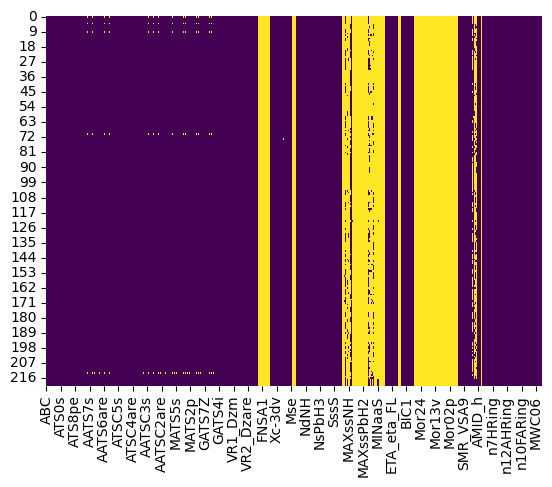

In [19]:
sns.heatmap(df3.isnull(), cbar=False, cmap="viridis")

Al tratarse de una base de datos con una gran cantidad de características, se eliminarán aquellas columnas que contengan valores faltantes. Esto también se realiza pues no se brinda información de la importancia física de las características, de forma que no sabemos si imputar datos podría afectar al resultado.

In [20]:
df3 = df3.dropna(axis=1)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Columns: 1329 entries, ABC to mZagreb2
dtypes: float64(1002), int64(327)
memory usage: 2.2 MB


# Pre-procesamiento de datos

## Base de datos de características 1 (RDKit)

Primero se verificará la redundancia entre las variables, por lo que se aplicará la matriz de correlación.

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221 entries, 1 to 281
Columns: 118 entries, MaxEStateIndex to fr_phenol_noOrthoHbond
dtypes: float64(86), int64(32)
memory usage: 205.5+ KB


<Axes: >

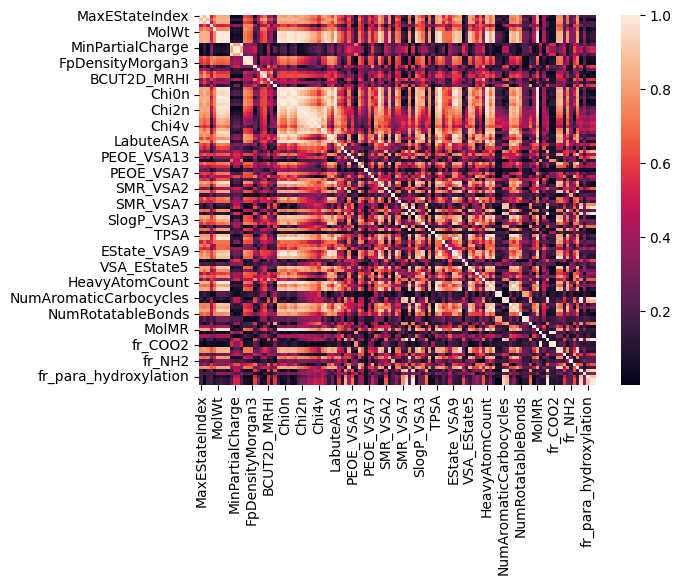

In [22]:
corr_mat = df1.corr().abs()
sns.heatmap(corr_mat)

In [23]:
columns = np.full((corr_mat.shape[0], ), True, dtype=bool)
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        if corr_mat.iloc[i,j] >= 0.95:
            if columns[j]:
                columns[j] = False
selected_columns = df1.columns[columns]
df1 = df1[selected_columns]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221 entries, 1 to 281
Data columns (total 68 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MaxEStateIndex            221 non-null    float64
 1   MinEStateIndex            221 non-null    float64
 2   MinAbsEStateIndex         221 non-null    float64
 3   qed                       221 non-null    float64
 4   MolWt                     221 non-null    float64
 5   MaxPartialCharge          221 non-null    float64
 6   MinPartialCharge          221 non-null    float64
 7   FpDensityMorgan1          221 non-null    float64
 8   BCUT2D_MWHI               221 non-null    float64
 9   BCUT2D_MWLOW              221 non-null    float64
 10  BCUT2D_CHGLO              221 non-null    float64
 11  BCUT2D_LOGPLOW            221 non-null    float64
 12  BCUT2D_MRHI               221 non-null    float64
 13  BCUT2D_MRLOW              221 non-null    float64
 14  BalabanJ       

## Base de datos de características 2 (Morgan fingerprints)

Realizamos el mismo procedimiento.

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Columns: 2048 entries, Col_0 to Col_2047
dtypes: int64(2048)
memory usage: 3.5 MB


Al tratarse de muchas columnas, no se mostrará el heatmap.

In [25]:
corr_mat = df2.corr().abs()

In [26]:
columns = np.full((corr_mat.shape[0], ), True, dtype=bool)
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        if corr_mat.iloc[i,j] >= 0.95:
            if columns[j]:
                columns[j] = False
selected_columns = df2.columns[columns]
df2 = df2[selected_columns]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Columns: 1666 entries, Col_0 to Col_2047
dtypes: int64(1666)
memory usage: 2.8 MB


## Base de datos de características 3 (Mordred)

Realizamos el mismo procedimiento.

In [27]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Columns: 1329 entries, ABC to mZagreb2
dtypes: float64(1002), int64(327)
memory usage: 2.2 MB


In [28]:
corr_mat = df3.corr().abs()

In [29]:
columns = np.full((corr_mat.shape[0], ), True, dtype=bool)
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        if corr_mat.iloc[i,j] >= 0.95:
            if columns[j]:
                columns[j] = False
selected_columns = df3.columns[columns]
df3 = df3[selected_columns]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Columns: 627 entries, ABC to SRW05
dtypes: float64(366), int64(261)
memory usage: 1.1 MB


## Base de datos unificada

Ahora que se eliminaron todas las variables redundantes, se realizará cuatro pruebas. Tomando cada base de datos por separado y tomando una base de datos unificada, por lo que se realizará el entrenamiento de estandarización por separado y en conjunto.

In [30]:
df1 = df1.reset_index(drop=True)
df = pd.concat([df1, df2, df3], axis=1, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Columns: 2361 entries, 0 to 2360
dtypes: float64(421), int64(1940)
memory usage: 4.0 MB


Se usará RobustScaler pues es el que se ha enseñado en clase.

In [31]:
rs = RobustScaler()
rs1 = RobustScaler()
rs2 = RobustScaler()
rs3 = RobustScaler()

df = rs.fit_transform(df)
df1 = rs1.fit_transform(df1)
df2 = rs2.fit_transform(df2)
df3 = rs3.fit_transform(df3)

## Base de datos de etiquetas

Para el trabajo se tomarán cuatro métodos para resolver el problema.

- Tomando las dos columnas con mayor cantidad de muestras
- Tomando las tres columnas con mayor cantidad de muestras
- Tomando todas las columnas
- Tomando todas las columnas y el número de grupos funcionales

### 1era forma

In [32]:
for col in df0.columns:
    print(f"{col} : {df0[col].unique()}")

hydroxamate : [0 3 2 1 4]
catecholate : [1 0 3 2]
a-hydroxycarboxylate : [0 2 1]
carboxylate : [1 0 2 4 3]
phenolate : [0 1 2]
citrate : [0 1 2]
other : [0 1]


Vemos que las dos columnas que más se repiten son hidroxamato y carboxilato, por lo que se tomarán estas.

In [33]:
y0 = df0[["hydroxamate", "carboxylate"]]
y0

,hydroxamate,carboxylate
ID,,
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
...,...,...
277,2,0
278,0,2
279,0,2


Convertimos todos los valores mayores a 0 en 1.

In [34]:
y0 = y0.applymap(lambda x: 1 if x > 0 else x)
y0

,hydroxamate,carboxylate
ID,,
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
...,...,...
277,1,0
278,0,1
279,0,1


Decodificamos las diferentes clases en números binarios.

In [35]:
def convert_to_output(number_list):
    return int("".join(map(str, number_list)), 2)
decoded = y0.apply(convert_to_output, axis=1)
y0 = pd.DataFrame(decoded, columns=["decoded"])
y0

,decoded
ID,
1,1
2,1
3,1
4,1
5,1
...,...
277,2
278,1
279,1


<Axes: xlabel='decoded'>

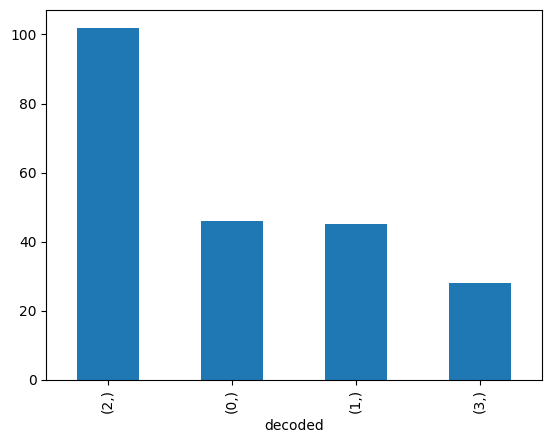

In [36]:
y0.value_counts().plot(kind="bar")

### 2da forma

In [37]:
for col in df0.columns:
    print(f"{col} : {df0[col].value_counts()}")

hydroxamate : 0    91
3    85
2    22
1    18
4     5
Name: hydroxamate, dtype: int64
catecholate : 0    153
2     27
1     23
3     18
Name: catecholate, dtype: int64
a-hydroxycarboxylate : 0    206
2      8
1      7
Name: a-hydroxycarboxylate, dtype: int64
carboxylate : 0    148
1     63
2      8
4      1
3      1
Name: carboxylate, dtype: int64
phenolate : 0    202
1     18
2      1
Name: phenolate, dtype: int64
citrate : 0    202
1     16
2      3
Name: citrate, dtype: int64
other : 0    204
1     17
Name: other, dtype: int64


A las dos columnas previamente mencionadas le agregamos la columna de catecholate.

In [38]:
y1 = df0[["hydroxamate", "carboxylate", "catecholate"]]
y1

,hydroxamate,carboxylate,catecholate
ID,,,
1,0,1,1
2,0,1,1
3,0,1,1
4,0,1,1
5,0,1,0
...,...,...,...
277,2,0,0
278,0,2,1
279,0,2,1


Convertimos todos los valores a 0s y 1s.

In [39]:
y1 = y1.applymap(lambda x: 1 if x > 0 else x)
y1

,hydroxamate,carboxylate,catecholate
ID,,,
1,0,1,1
2,0,1,1
3,0,1,1
4,0,1,1
5,0,1,0
...,...,...,...
277,1,0,0
278,0,1,1
279,0,1,1


Decodificamos las diferentes clases en números binarios.

In [40]:
decoded = y1.apply(convert_to_output, axis=1)
y1 = pd.DataFrame(decoded, columns=["decoded"])
y1

,decoded
ID,
1,3
2,3
3,3
4,3
5,2
...,...
277,4
278,3
279,3


<Axes: xlabel='decoded'>

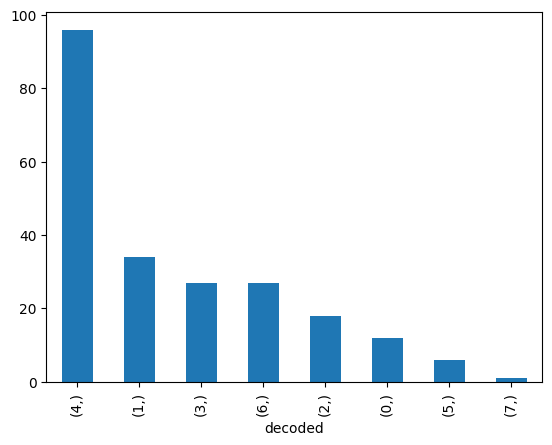

In [41]:
y1.value_counts().plot(kind="bar")

Es importante notar que hay muy pocos casos donde se den las tres columnas al mismo tiempo, esto puede ser una fuente de error, por lo que se eliminarán aquellas muestras (filas) que pertenezcan a clases que se repitan menos de 5 veces.

<Axes: xlabel='decoded'>

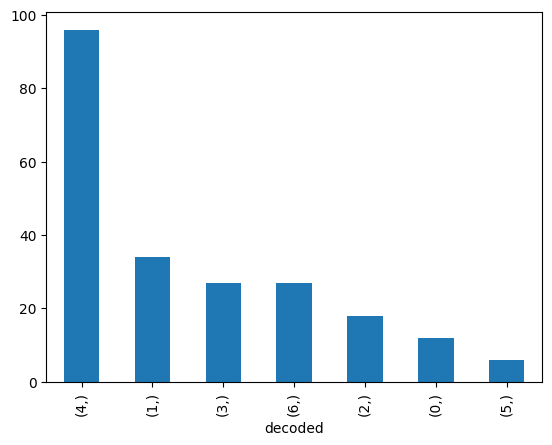

In [42]:
counts = y1["decoded"].value_counts()
new_values = counts[counts >= 5].index.to_list()
mask1 = y1["decoded"].isin(new_values)
y1 = y1[mask1]
y1.value_counts().plot(kind="bar")

### 3ra forma

In [43]:
y2 = df0.applymap(lambda x: 1 if x > 0 else x)
y2

,hydroxamate,catecholate,a-hydroxycarboxylate,carboxylate,phenolate,citrate,other
ID,,,,,,,
1,0,1,0,1,0,0,0
2,0,1,0,1,0,0,0
3,0,1,0,1,0,0,0
4,0,1,0,1,0,0,0
5,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...
277,1,0,0,0,0,0,0
278,0,1,0,1,0,0,1
279,0,1,0,1,0,0,1


In [44]:
decoded = y2.apply(convert_to_output, axis=1)
y2 = pd.DataFrame(decoded, columns=["decoded"])
y2

,decoded
ID,
1,40
2,40
3,40
4,40
5,12
...,...
277,64
278,41
279,41


<Axes: xlabel='decoded'>

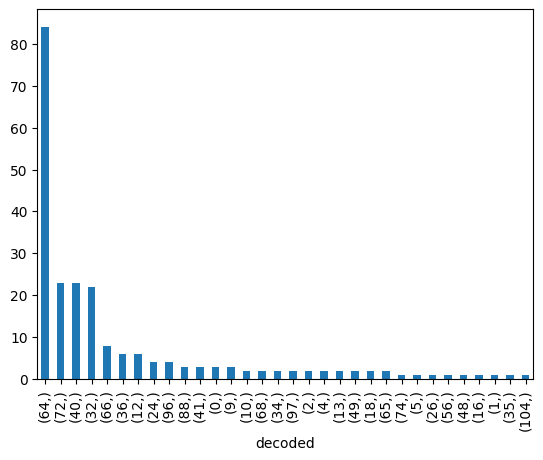

In [45]:
y2.value_counts().plot(kind="bar")

Realizamos el mismo procedimiento que para la segunda forma para eliminar las muestras que pertenezcan a clases que no se repitan al menos 5 veces.

<Axes: xlabel='decoded'>

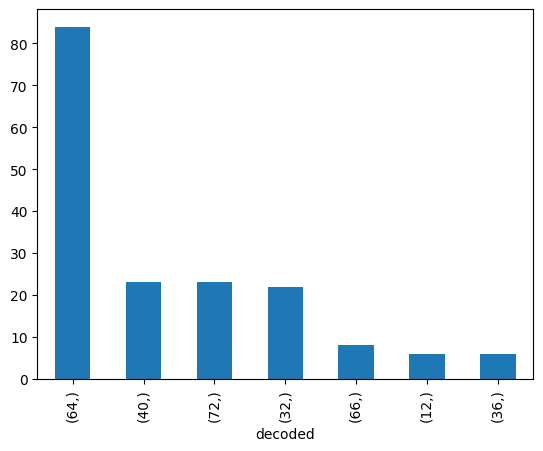

In [46]:
counts = y2["decoded"].value_counts()
new_values = counts[counts >= 5].index.to_list()
mask2 = y2["decoded"].isin(new_values)
y2 = y2[mask2]
y2.value_counts().plot(kind="bar")

Notemos que la cantidad de clases que se clasificará es la misma que en la segunda forma, no obstante, esta vez la búsqueda es más específica pues también considera el resto de grupos funcionales.

### 4ta forma 

In [47]:
y3 = df0
def convert_to_output(number_list):
    return int("".join(map(str, number_list)), 10)
decoded = y3.apply(convert_to_output, axis=1)
y3 = pd.DataFrame(decoded, columns=["decoded"])
y3

,decoded
ID,
1,101000
2,101000
3,101000
4,101000
5,1100
...,...
277,2000000
278,102001
279,102001


<Axes: xlabel='decoded'>

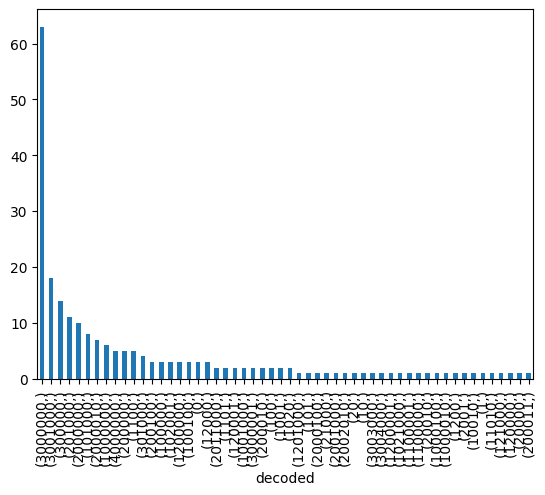

In [48]:
y3.value_counts().plot(kind="bar")

Nuevamente, eliminamos las clases que tengan menos de 5 ocurrencias.

<Axes: xlabel='decoded'>

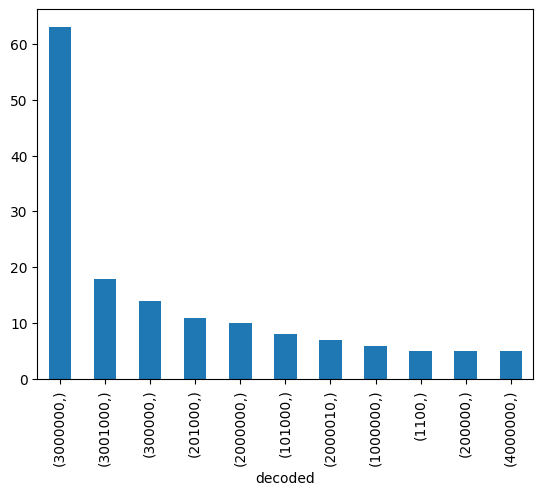

In [49]:
counts = y3["decoded"].value_counts()
new_values = counts[counts >= 5].index.to_list()
mask3 = y3["decoded"].isin(new_values)
y3 = y3[mask3]
y3.value_counts().plot(kind="bar")

Ahora tenemos 11 clases específicas según la cantidad de grupos funcionales que contienen.

# Modelos de clasificación

Los modelos tratados hasta el momento son K-Nearest Neighbors, Naive Bayes, Random Forest y Support Vector Machine, por lo que usaremos estos.

## Tomando la base de datos unificada

### 1era forma

In [50]:
X0_train, X0_test, y0_train, y0_test = train_test_split(df, y0, test_size=0.2, random_state=42)
X0_train.shape, X0_test.shape, y0_train.shape, y0_test.shape

((176, 2361), (45, 2361), (176, 1), (45, 1))

In [51]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [52]:
for model in model_list:
    model.fit(X0_train, y0_train)
    y_pred = model.predict(X0_test)
    acc.append(accuracy_score(y0_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\508658203.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X0_train, y0_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

In [53]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.756
NB,0.733
RF,0.844
SVM,0.556


### 2da forma

In [54]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df[mask1], y1, test_size=0.2, random_state=42)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((176, 2361), (44, 2361), (176, 1), (44, 1))

In [55]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [56]:
for model in model_list:
    model.fit(X1_train, y1_train)
    y_pred = model.predict(X1_test)
    acc.append(accuracy_score(y1_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\4043230114.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X1_train, y1_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [57]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.636
NB,0.500
RF,0.818
SVM,0.614


### 3ra forma

In [58]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df[mask2], y2, test_size=0.2, random_state=42)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((137, 2361), (35, 2361), (137, 1), (35, 1))

In [59]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [60]:
for model in model_list:
    model.fit(X2_train, y2_train)
    y_pred = model.predict(X2_test)
    acc.append(accuracy_score(y2_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\3415018584.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X2_train, y2_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [61]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.629
NB,0.743
RF,0.971
SVM,0.457


### 4ta forma

In [62]:
X3_train, X3_test, y3_train, y3_test = train_test_split(df[mask3], y3, test_size=0.2, random_state=42)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((121, 2361), (31, 2361), (121, 1), (31, 1))

In [63]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [64]:
for model in model_list:
    model.fit(X3_train, y3_train)
    y_pred = model.predict(X3_test)
    acc.append(accuracy_score(y3_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\2288442450.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X3_train, y3_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [65]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.581
NB,0.839
RF,0.935
SVM,0.452


## Tomando la base de datos 1

### 1era forma

In [66]:
X0_train, X0_test, y0_train, y0_test = train_test_split(df1, y0, test_size=0.2, random_state=42)
X0_train.shape, X0_test.shape, y0_train.shape, y0_test.shape

((176, 68), (45, 68), (176, 1), (45, 1))

In [67]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [68]:
for model in model_list:
    model.fit(X0_train, y0_train)
    y_pred = model.predict(X0_test)
    acc.append(accuracy_score(y0_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\508658203.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X0_train, y0_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

In [69]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.822
NB,0.756
RF,0.889
SVM,0.778


### 2da forma

In [70]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df1[mask1], y1, test_size=0.2, random_state=42)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((176, 68), (44, 68), (176, 1), (44, 1))

In [71]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [72]:
for model in model_list:
    model.fit(X1_train, y1_train)
    y_pred = model.predict(X1_test)
    acc.append(accuracy_score(y1_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\4043230114.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X1_train, y1_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [73]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.795
NB,0.727
RF,0.795
SVM,0.750


### 3ra forma

In [74]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df1[mask2], y2, test_size=0.2, random_state=42)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((137, 68), (35, 68), (137, 1), (35, 1))

In [75]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [76]:
for model in model_list:
    model.fit(X2_train, y2_train)
    y_pred = model.predict(X2_test)
    acc.append(accuracy_score(y2_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\3415018584.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X2_train, y2_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [77]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.714
NB,0.857
RF,0.914
SVM,0.771


### 4ta forma

In [78]:
X3_train, X3_test, y3_train, y3_test = train_test_split(df1[mask3], y3, test_size=0.2, random_state=42)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((121, 68), (31, 68), (121, 1), (31, 1))

In [79]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [80]:
for model in model_list:
    model.fit(X3_train, y3_train)
    y_pred = model.predict(X3_test)
    acc.append(accuracy_score(y3_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\2288442450.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X3_train, y3_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [81]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.839
NB,0.742
RF,0.968
SVM,0.935


## Tomando la base de datos 2

### 1era forma

In [82]:
X0_train, X0_test, y0_train, y0_test = train_test_split(df2, y0, test_size=0.2, random_state=42)
X0_train.shape, X0_test.shape, y0_train.shape, y0_test.shape

((176, 1666), (45, 1666), (176, 1), (45, 1))

In [83]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [84]:
for model in model_list:
    model.fit(X0_train, y0_train)
    y_pred = model.predict(X0_test)
    acc.append(accuracy_score(y0_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\508658203.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X0_train, y0_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

In [85]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.867
NB,0.867
RF,0.867
SVM,0.867


### 2da forma

In [86]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df2[mask1], y1, test_size=0.2, random_state=42)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((176, 1666), (44, 1666), (176, 1), (44, 1))

In [87]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [88]:
for model in model_list:
    model.fit(X1_train, y1_train)
    y_pred = model.predict(X1_test)
    acc.append(accuracy_score(y1_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\4043230114.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X1_train, y1_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [89]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.886
NB,0.909
RF,0.909
SVM,0.864


### 3ra forma

In [90]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df2[mask2], y2, test_size=0.2, random_state=42)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((137, 1666), (35, 1666), (137, 1), (35, 1))

In [91]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [92]:
for model in model_list:
    model.fit(X2_train, y2_train)
    y_pred = model.predict(X2_test)
    acc.append(accuracy_score(y2_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\3415018584.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X2_train, y2_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [93]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.829
NB,0.914
RF,0.943
SVM,0.914


### 4ta forma

In [94]:
X3_train, X3_test, y3_train, y3_test = train_test_split(df2[mask3], y3, test_size=0.2, random_state=42)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((121, 1666), (31, 1666), (121, 1), (31, 1))

In [95]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [96]:
for model in model_list:
    model.fit(X3_train, y3_train)
    y_pred = model.predict(X3_test)
    acc.append(accuracy_score(y3_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\2288442450.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X3_train, y3_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [97]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.677
NB,0.742
RF,0.839
SVM,0.710


## Tomando la base de datos 3

### 1era forma

In [98]:
X0_train, X0_test, y0_train, y0_test = train_test_split(df3, y0, test_size=0.2, random_state=42)
X0_train.shape, X0_test.shape, y0_train.shape, y0_test.shape

((176, 627), (45, 627), (176, 1), (45, 1))

In [99]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [100]:
for model in model_list:
    model.fit(X0_train, y0_train)
    y_pred = model.predict(X0_test)
    acc.append(accuracy_score(y0_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\508658203.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X0_train, y0_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

In [101]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.733
NB,0.733
RF,0.867
SVM,0.556


### 2da forma

In [102]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df3[mask1], y1, test_size=0.2, random_state=42)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((176, 627), (44, 627), (176, 1), (44, 1))

In [103]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [104]:
for model in model_list:
    model.fit(X1_train, y1_train)
    y_pred = model.predict(X1_test)
    acc.append(accuracy_score(y1_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\4043230114.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X1_train, y1_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [105]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.636
NB,0.318
RF,0.795
SVM,0.614


### 3ra forma

In [106]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df3[mask2], y2, test_size=0.2, random_state=42)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((137, 627), (35, 627), (137, 1), (35, 1))

In [107]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [108]:
for model in model_list:
    model.fit(X2_train, y2_train)
    y_pred = model.predict(X2_test)
    acc.append(accuracy_score(y2_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\3415018584.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X2_train, y2_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [109]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.657
NB,0.743
RF,0.943
SVM,0.457


### 4ta forma

In [110]:
X3_train, X3_test, y3_train, y3_test = train_test_split(df3[mask3], y3, test_size=0.2, random_state=42)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((121, 627), (31, 627), (121, 1), (31, 1))

In [111]:
model_list = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(random_state=42), SVC(random_state=42)]
model_name_list = ["KNN", "NB", "RF", "SVM"]
acc = []

In [112]:
for model in model_list:
    model.fit(X3_train, y3_train)
    y_pred = model.predict(X3_test)
    acc.append(accuracy_score(y3_test, y_pred))

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\2288442450.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X3_train, y3_train)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

In [113]:
performance_df = pd.DataFrame(
    index = ["Acc"],
    columns = model_name_list,
    data=[acc]
).T
pd.options.display.precision = 3
performance_df

,Acc
KNN,0.548
NB,0.839
RF,0.903
SVM,0.452


# Tuneo de modelos

El tuneo de los modeloa se realizarán para aquellos modelos que obtuvieron mejores resultados para las 4 formas de solucionar el roblema que se plantearon en este trabajo.

## 1ra forma

Para encontrar aquellas moléculas que contengan hidroxamato y carboxilato (y las combinaciones posibles), la mejor solución fue aplicando RandomForest a la Base de Datos 1.

In [114]:
X0_train, X0_test, y0_train, y0_test = train_test_split(df1, y0, test_size=0.2, random_state=42)
X0_train.shape, X0_test.shape, y0_train.shape, y0_test.shape

((176, 68), (45, 68), (176, 1), (45, 1))

In [115]:
model1 = RandomForestClassifier(random_state=42)

In [116]:
model1_params = {
    "n_estimators": [int(x) for x in np.arange(100, 2000, 100)],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [int(x) for x in np.arange(10, 100, 10)],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 2, 4, 8],
    "min_samples_split": [2, 5, 10, 20],
}

In [117]:
model1_random = RandomizedSearchCV(
    estimator=model1,
    param_distributions=model1_params,
    n_iter=300,
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
model1_random.fit(X0_train, y0_train)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900]},
                   random_state=42, verbose=2)

In [118]:
model1_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 30,
 'criterion': 'log_loss'}

In [119]:
base_model = RandomForestClassifier(random_state=42)
base_model.fit(X0_train, y0_train)
base_accuracy = accuracy_score(y0_test, base_model.predict(X0_test))
print(f"Base Model Performance: {base_accuracy*100:.5f}%")

best_random = model1_random.best_estimator_
best_random_accuracy = accuracy_score(y0_test, best_random.predict(X0_test))
print(f"Best Random Model: {best_random_accuracy*100:.5f}%")

Base Model Performance: 88.88889%
Best Random Model: 88.88889%


C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\2503734303.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X0_train, y0_train)


No hay mucha diferencia entre el modelo base y el mejor modelo obtenido con parámetros randomizados, de todas formas se utilizará el método GridSearchCV para ver si se puede mejorar el modelo usando valores cercanos a los vistos usando parámetros randomizados.

In [120]:
model1 = RandomForestClassifier(random_state=42)

In [121]:
model1_params = {
    "n_estimators": [250, 275, 300, 325, 350],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [25, 30, 35],
    "max_features": [None],
    "min_samples_leaf": [1],
    "min_samples_split": [3, 4, 5, 6, 7],
}

In [122]:
grid_search = GridSearchCV(
    model1,
    model1_params,
    cv=4,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X0_train, y0_train)

Fitting 4 folds for each of 225 candidates, totalling 900 fits


c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [25, 30, 35], 'max_features': [None],
                         'min_samples_leaf': [1],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'n_estimators': [250, 275, 300, 325, 350]},
             verbose=2)

In [123]:
best_grid = grid_search.best_estimator_
grid_accuracy = accuracy_score(y0_test, best_grid.predict(X0_test))
print(f"Best Grid Model: {grid_accuracy*100:.5f}%")

Best Grid Model: 88.88889%


Se obtuvo los mismos resultados, de forma que la única manera de aumentar la precisión del modelo es a través de feature engineering. No obstante, al no tener el conocimiento de la importancia física de las variables, no se realizará este paso.

In [124]:
best_model1 = grid_search.best_estimator_

## 2da forma

Para encontrar aquellas moléculas que contengan hidroxamato, carboxilato y catecolato (y las combinaciones posibles), la mejor solución fue aplicando RandomForest o Naive Bayes a la Base de Datos 2.

In [125]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df2[mask1], y1, test_size=0.2, random_state=42)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((176, 1666), (44, 1666), (176, 1), (44, 1))

In [126]:
model2 = RandomForestClassifier(random_state=42)

In [127]:
model2_params = {
    "n_estimators": [int(x) for x in np.arange(100, 2000, 100)],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [int(x) for x in np.arange(10, 100, 10)],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 2, 4, 8],
    "min_samples_split": [2, 5, 10, 20],
}

In [128]:
model2_random = RandomizedSearchCV(
    estimator=model2,
    param_distributions=model2_params,
    n_iter=300,
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
model2_random.fit(X1_train, y1_train)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900]},
                   random_state=42, verbose=2)

In [129]:
model2_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 50,
 'criterion': 'log_loss'}

In [130]:
base_model = RandomForestClassifier(random_state=42)
base_model.fit(X1_train, y1_train)
base_accuracy = accuracy_score(y1_test, base_model.predict(X1_test))
print(f"Base Model Performance: {base_accuracy*100:.5f}%")

best_random = model2_random.best_estimator_
best_random_accuracy = accuracy_score(y1_test, best_random.predict(X1_test))
print(f"Best Random Model: {best_random_accuracy*100:.5f}%")

Base Model Performance: 90.90909%
Best Random Model: 86.36364%


C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\1655193472.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X1_train, y1_train)


In [131]:
best_random_accuracy = accuracy_score(y1_train, best_random.predict(X1_train))
print(f"Best Random Model: {best_random_accuracy*100:.5f}%")

Best Random Model: 100.00000%


Notemos que se obtuvo un caso de overfitting, pues la precisión en el set de entrenamiento es del 100% y la precisión en el set de testeo se redujo comparado al modelo base. Por estos motivos, para el método GirdSearchCV se usarán valores cercanos a los parámetros del modelo base.

In [132]:
model2 = RandomForestClassifier(random_state=42)

In [133]:
model2_params = {
    "n_estimators": [50, 100, 150, 200, 250],
    "criterion": ["gini", "entropy", "log_loss"],
    "min_samples_leaf": [1],
    "min_samples_split": [2, 3, 4, 5]
}

In [134]:
grid_search = GridSearchCV(
    model2,
    model2_params,
    cv=4,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X1_train, y1_train)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [1],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [50, 100, 150, 200, 250]},
             verbose=2)

In [135]:
best_grid = grid_search.best_estimator_
grid_accuracy = accuracy_score(y1_test, best_grid.predict(X1_test))
print(f"Best Grid Model: {grid_accuracy*100:.5f}%")

Best Grid Model: 86.36364%


In [136]:
grid_accuracy = accuracy_score(y1_train, best_grid.predict(X1_train))
print(f"Best Grid Model: {grid_accuracy*100:.5f}%")

Best Grid Model: 99.43182%


Al igual que con los hiperparámetros randomizados, se da un caso de overfitting, esto da a entender que el modelo de RandomForest tiende a sobreajustar los parámetros para que se memorice los datos de entrenamiento, de forma que el feature engineering se vuelve un paso importante para mejorar los modelos.

In [137]:
best_model2 = RandomForestClassifier(random_state=42)
best_model2.fit(X1_train, y1_train)

C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\195279941.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model2.fit(X1_train, y1_train)


RandomForestClassifier(random_state=42)

## 3ra forma

Para encontrar aquellas moléculas que contengan las diferentes combinaciones posibles de la existencia de los grupos funcionales del dataset, la mejor solución fue aplicando RandomForest a la Base de Datos Unificada.

In [138]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df[mask2], y2, test_size=0.2, random_state=42)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((137, 2361), (35, 2361), (137, 1), (35, 1))

In [139]:
model3 = RandomForestClassifier(random_state=42)

In [140]:
model3_params = {
    "n_estimators": [int(x) for x in np.arange(100, 2000, 100)],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [int(x) for x in np.arange(10, 100, 10)],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 2, 4, 8],
    "min_samples_split": [2, 5, 10, 20],
}

In [141]:
model3_random = RandomizedSearchCV(
    estimator=model3,
    param_distributions=model3_params,
    n_iter=300,
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
model3_random.fit(X2_train, y2_train)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900]},
                   random_state=42, verbose=2)

In [142]:
model3_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 50,
 'criterion': 'log_loss'}

In [143]:
base_model = RandomForestClassifier(random_state=42)
base_model.fit(X2_train, y2_train)
base_accuracy = accuracy_score(y2_test, base_model.predict(X2_test))
print(f"Base Model Performance: {base_accuracy*100:.5f}%")

best_random = model3_random.best_estimator_
best_random_accuracy = accuracy_score(y2_test, best_random.predict(X2_test))
print(f"Best Random Model: {best_random_accuracy*100:.5f}%")

Base Model Performance: 97.14286%
Best Random Model: 97.14286%


C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\3360914509.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X2_train, y2_train)


In [144]:
best_random_accuracy = accuracy_score(y2_train, best_random.predict(X2_train))
print(f"Best Random Model: {best_random_accuracy*100:.5f}%")

Best Random Model: 100.00000%


Notemos que las precisiones son muy similares, esto puede ser un indicador de que se alcanzó la mejor precisión posible en modelos sin realizar un procedimiento de feature engineering. Se procede a utilizar el método GridSearchCV para verificar si se puede aumentar ligeramente la precisión.

In [145]:
model3 = RandomForestClassifier(random_state=42)

In [146]:
model3_params = {
    "n_estimators": [1700, 1750, 1800, 1850, 1900],
    "criterion": ["log_loss"],
    "min_samples_split": [2, 4, 8],
    "min_samples_leaf": [1, 2, 4],
    "max_depth": [50]
}

In [147]:
grid_search = GridSearchCV(
    model3,
    model3_params,
    cv=4,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X2_train, y2_train)

Fitting 4 folds for each of 45 candidates, totalling 180 fits


c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['log_loss'], 'max_depth': [50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [1700, 1750, 1800, 1850, 1900]},
             verbose=2)

In [148]:
best_grid = grid_search.best_estimator_
grid_accuracy = accuracy_score(y2_test, best_grid.predict(X2_test))
print(f"Best Grid Model: {grid_accuracy*100:.5f}%")

Best Grid Model: 97.14286%


In [149]:
grid_accuracy = accuracy_score(y2_train, best_grid.predict(X2_train))
print(f"Best Grid Model: {grid_accuracy*100:.5f}%")

Best Grid Model: 100.00000%


No hubo cambios en la precisión, por lo que se mantendrá el modelo predeterminado como el modelo ideal. Este resultado indica que el modelo consigue obtener los mejores resultados posibles a falta de un procedimiento de feature engineering.

In [150]:
best_model3 = RandomForestClassifier(random_state=42)
best_model3.fit(X2_train, y2_train)

C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\2470241125.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model3.fit(X2_train, y2_train)


RandomForestClassifier(random_state=42)

## 4ta forma

Para encontrar aquellas moléculas que contengan las diferentes combinaciones posibles de los grupos funcionales y la cantidad de estos, la mejor solución fue aplicando Random Forest a la Base de Datos 1.

In [151]:
X3_train, X3_test, y3_train, y3_test = train_test_split(df1[mask3], y3, test_size=0.2, random_state=42)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((121, 68), (31, 68), (121, 1), (31, 1))

In [152]:
model4 = RandomForestClassifier(random_state=42)

In [153]:
model4_params = {
    "n_estimators": [int(x) for x in np.arange(100, 2000, 100)],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [int(x) for x in np.arange(10, 100, 10)],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 2, 4, 8],
    "min_samples_split": [2, 5, 10, 20],
}

In [154]:
model4_random = RandomizedSearchCV(
    estimator=model4,
    param_distributions=model4_params,
    n_iter=300,
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
model4_random.fit(X3_train, y3_train)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900]},
                   random_state=42, verbose=2)

In [155]:
model4_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 50,
 'criterion': 'log_loss'}

In [156]:
base_model = RandomForestClassifier(random_state=42)
base_model.fit(X3_train, y3_train)
base_accuracy = accuracy_score(y3_test, base_model.predict(X3_test))
print(f"Base Model Performance: {base_accuracy*100:.5f}%")

best_random = model4_random.best_estimator_
best_random_accuracy = accuracy_score(y3_test, best_random.predict(X3_test))
print(f"Best Random Model: {best_random_accuracy*100:.5f}%")

Base Model Performance: 96.77419%
Best Random Model: 93.54839%


C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\3299999635.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X3_train, y3_train)


In [157]:
best_random_accuracy = accuracy_score(y3_train, best_random.predict(X3_train))
print(f"Best Random Model: {best_random_accuracy*100:.5f}%")

Best Random Model: 100.00000%


Notemos que el modelo obtenido con hiperparámetros randomizados ha overfitteado, por lo que el GridSearch se realizará con parámetros similares a los hiperparámetros predeterminados.

In [158]:
model4 = RandomForestClassifier(random_state=42)

In [159]:
model4_params = {
    "n_estimators": [50, 100, 150, 200, 250],
    "criterion": ["gini", "entropy", "log_loss"],
    "min_samples_leaf": [1],
    "min_samples_split": [2, 3, 4, 5]
}

In [160]:
grid_search = GridSearchCV(
    model4,
    model4_params,
    cv=4,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X3_train, y3_train)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [1],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [50, 100, 150, 200, 250]},
             verbose=2)

In [161]:
best_grid = grid_search.best_estimator_
grid_accuracy = accuracy_score(y3_test, best_grid.predict(X3_test))
print(f"Best Grid Model: {grid_accuracy*100:.5f}%")

Best Grid Model: 96.77419%


De todas formas, no se consiguió una mejora, por lo que se utilizarán los hiperparámetros por predeterminado.

In [162]:
best_model4 = RandomForestClassifier(random_state=42)
best_model4.fit(X3_train, y3_train)

C:\Users\eavil\AppData\Local\Temp\ipykernel_55872\3607887479.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model4.fit(X3_train, y3_train)


RandomForestClassifier(random_state=42)

# Métricas de evaluación

Las métricas de evaluación se realizarán para aquellos modelos que obtuvieron mejores resultados para las 4 formas de solucionar el problema que se plantearon en este trabajo.

Cabe destacar que las métricas de evaluación de modelos de clasificación múltiple se obtuvieron del paper ["Metrics for Multi-Class Classification: an Overview"](https://arxiv.org/abs/2008.05756).

## 1ra forma

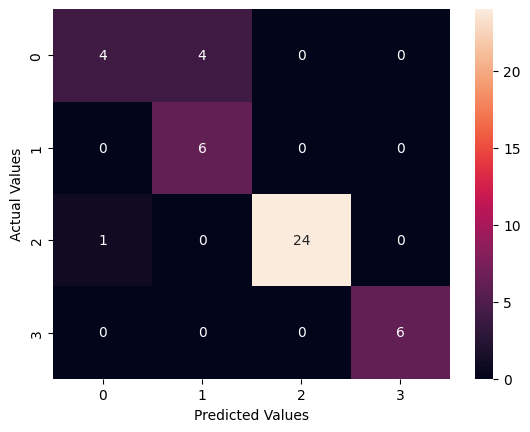

In [163]:
cm = confusion_matrix(y0_test, best_model1.predict(X0_test))
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [164]:
for idx, sample in enumerate(X0_test):
    pred = best_model1.predict(np.reshape(sample, (-1, len(sample))))
    if (pred != y0_test.iloc[idx].item()):
        print(f"Predicted value: {pred.item()} | Actual value: {y0_test.iloc[idx].item()}")

Predicted value: 1 | Actual value: 0
Predicted value: 1 | Actual value: 0
Predicted value: 1 | Actual value: 0
Predicted value: 0 | Actual value: 2
Predicted value: 1 | Actual value: 0


El modelo se equivoca al predecir una molécula que contiene hidroxamato pero no carboxilato (10 - 2), y se equivoca al predecir cuatro moléculas que no contienen ni hidroxamato ni carboxilato (00 - 0). Con el resto de clases, el modelo no se equivoca.

In [165]:
preds = best_model1.predict(X0_test)
acc = accuracy_score(y0_test, preds)
pre_macro = precision_score(y0_test, preds, average="macro")
pre_micro = precision_score(y0_test, preds, average="micro")
recall_macro = recall_score(y0_test, preds, average="macro")
recall_micro = recall_score(y0_test, preds, average="micro")
f1_macro = f1_score(y0_test, preds, average="macro")
f1_micro = f1_score(y0_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 88.89%
Macro-averaged Precision: 85.00%
Macro-averaged Recall: 86.50%
Macro-averaged F1 Score: 83.62%


## 2da forma

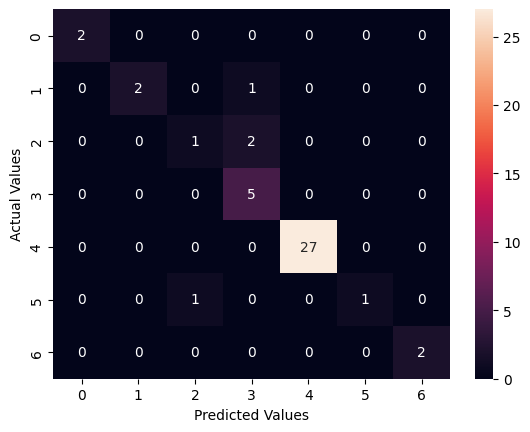

In [166]:
cm = confusion_matrix(y1_test, best_model2.predict(X1_test))
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [167]:
for idx, sample in enumerate(X1_test):
    pred = best_model2.predict(np.reshape(sample, (-1, len(sample))))
    if (pred != y1_test.iloc[idx].item()):
        print(f"Predicted value: {pred.item()} | Actual value: {y1_test.iloc[idx].item()}")

Predicted value: 3 | Actual value: 2
Predicted value: 3 | Actual value: 2
Predicted value: 2 | Actual value: 5
Predicted value: 3 | Actual value: 1


El modelo se confunde con una molécula que contiene hidroxamate y catecolato pero no carboxilato (101 - 5) con una molécula que contiene sólo carboxilato (010 - 2). También se confunde con una molécula que contiene únicamente catecolato (001 - 1) y dos moléculas que contienen únicamente carboxilato (010 - 2) con moléculas que contienen carboxilato y catecolato (011 - 3).

In [168]:
preds = best_model2.predict(X1_test)
acc = accuracy_score(y1_test, preds)
pre_macro = precision_score(y1_test, preds, average="macro")
pre_micro = precision_score(y1_test, preds, average="micro")
recall_macro = recall_score(y1_test, preds, average="macro")
recall_micro = recall_score(y1_test, preds, average="micro")
f1_macro = f1_score(y1_test, preds, average="macro")
f1_micro = f1_score(y1_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 90.91%
Macro-averaged Precision: 87.50%
Macro-averaged Recall: 78.57%
Macro-averaged F1 Score: 80.51%


## 3ra forma

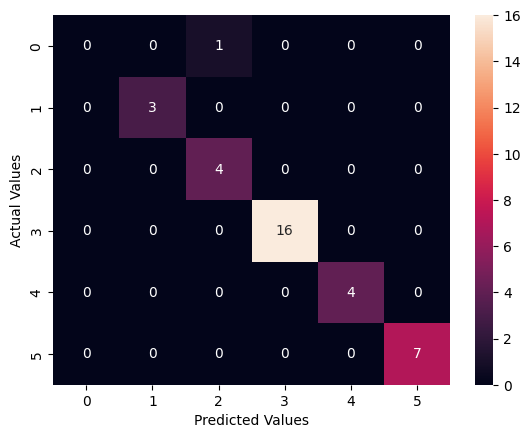

In [169]:
cm = confusion_matrix(y2_test, best_model3.predict(X2_test))
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [170]:
for idx, sample in enumerate(X2_test):
    pred = best_model3.predict(np.reshape(sample, (-1, len(sample))))
    if (pred != y2_test.iloc[idx].item()):
        print(f"Predicted value: {pred.item()} | Actual value: {y2_test.iloc[idx].item()}")

Predicted value: 40 | Actual value: 12


El modelo se confunde únicamente en un caso, confunda una molécula que contiene sólo carboxilato y fenolato (0001100), con una moléculas que contiene sólo catecolato y carboxilato (0101000). Cabe destacar que una de las clases no es considerada dentro del set de testeo, esto puede deberse a que contenía una cantidad de muestras muy pequeña, de forma que al aleatorizar el split entre test de entrenamiento y de testeo, no se obtuvo muestras para una de las clases. Esto es una limitación de esta forma de resolver el problema pues se cuenta con una cantidad de datos pequeña.

In [171]:
preds = best_model3.predict(X2_test)
acc = accuracy_score(y2_test, preds)
pre_macro = precision_score(y2_test, preds, average="macro")
pre_micro = precision_score(y2_test, preds, average="micro")
recall_macro = recall_score(y2_test, preds, average="macro")
recall_micro = recall_score(y2_test, preds, average="micro")
f1_macro = f1_score(y2_test, preds, average="macro")
f1_micro = f1_score(y2_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 97.14%
Macro-averaged Precision: 80.00%
Macro-averaged Recall: 83.33%
Macro-averaged F1 Score: 81.48%


c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4ta forma

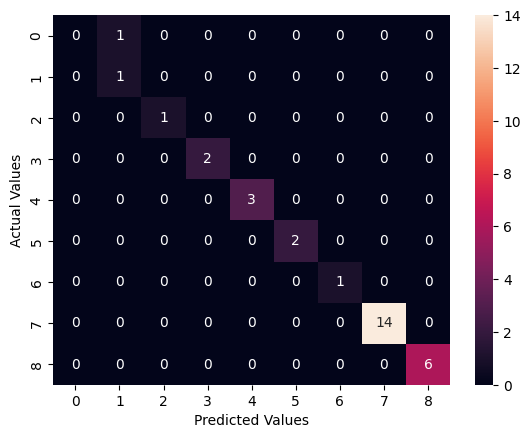

In [172]:
cm = confusion_matrix(y3_test, best_model4.predict(X3_test))
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [173]:
for idx, sample in enumerate(X3_test):
    pred = best_model4.predict(np.reshape(sample, (-1, len(sample))))
    if (pred != y3_test.iloc[idx].item()):
        print(f"Predicted value: {pred.item()} | Actual value: {y3_test.iloc[idx].item()}")

Predicted value: 101000 | Actual value: 1100


El modelo se confunde únicamente en un caso, confunde una molécula que contiene un grupo funcional de carboxilato y un grupo de fenolato (0001100 - 1100) con una molécula que contiene un grupo funcional de catecolato y un grupo funcional de carboxilato (0101000 - 101000), es importante notar que en la 3era forma de resolver el problema también se encuentra este error por parte de los modelos, una posible razón de este es que el etiquetado haya sido incorrecto, o que las características de ambos compuestos sean muy similares.

In [174]:
preds = best_model4.predict(X3_test)
acc = accuracy_score(y3_test, preds)
pre_macro = precision_score(y3_test, preds, average="macro")
pre_micro = precision_score(y3_test, preds, average="micro")
recall_macro = recall_score(y3_test, preds, average="macro")
recall_micro = recall_score(y3_test, preds, average="micro")
f1_macro = f1_score(y3_test, preds, average="macro")
f1_micro = f1_score(y3_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 96.77%
Macro-averaged Precision: 83.33%
Macro-averaged Recall: 88.89%
Macro-averaged F1 Score: 85.19%


c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusiones

Se concluye que para clasificar las moléculas que contengan **hidroxamato y carboxilato** (y las combinaciones posibles), basta con utilizar las características de la Base de Datos 1, es decir con el **RDKit**, con una precisión de hasta el **88.89%** usando RandomForest con los hiperparámetros detallados previamente.

Con respecto a la clasificación de moléculas que contengan **hidroxamato, catecolato y carboxilato** (y las combinaciones posibles), basta con utilizar las características de la Base de Datos 2, es decir con las **Morgan fingerprints**, con una precisión de hasta el **90.91%** usando RandomForest con los hiperparámetros predeterminados.

Luego, para la clasificación de moléculas que contengan **todos los grupos funcionales y sus diferentes combinaciones posibles** con clases que cuenten con al menos 5 muestras se necesita de la **Base de Datos unificada** pues confiere de más información. Con esta se alcanza una precisión de hasta el **97.14%** usando RandomForest con los hiperparámetros predeterminados.

Además, para la clasificación de moléculas que contengan **todos los grupos funcionales (con sus cantidades) y sus diferentes combinaciones posibles** con al menos 5 muestras se necesita de la Base de Datos 1, es decir con el **RDKit**, con una precisión de hasta el **96.77%** usando RandomForest con los hiperparámetros predeterminados.

Notemos que para ningún caso se necesitó de la Base de Datos 3 Mordred, es posible que se deba a que esta base de datos contaba con muchos valores faltantes, los cuales podían ser importantes para la clasificación pero que se eliminaron para facilitar el procesamiento de las características pues no contábamos con contexto acerca del significado física de cada variable.

Por otro lado, la mayoría de soluciones requerían únicamente de los hiperparámetros predeterminados, esto puede ser indicio de dos cosas: la primera es que la cantidad de datos es mucho mayor a la cantidad de clases, de forma que el entrenamiento de los modelos conseguirá resultados más fiables luego de eliminar las variables redudantes, de manera que un cambio en los hiperparámetros no significará un aumento significativo de la precisión, no obstante, esto se podría mejorar un procedimiento de feature engineering, en el que se reduzcan la cantidad de variables, o se generen nuevas variables a partir de las actuales para mejorar el entrenamiento, etc; y segundo es que con los datos en bruto, es más problable que se obtengan casos de overfitting como se vio en el tuneo de los modelos para las distintas formas de resolver el problema.

Finalmente, la limitación más importante de la base de datos es la cantidad de muestras que pertenecían a cada clase, esto hizo que parte de las muestras sean removidas para que al menos hayan 5 muestras por cada clase, agregar más entradas de moléculas con sus diferentes composiciones químicas permitirían validar los modelos obtenidos o mejorarlos para aplicaciones prácticas.